<a href="https://colab.research.google.com/github/AndrewCPU2/Kaggle-comps/blob/main/AprilSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e4_path = kagglehub.competition_download('playground-series-s5e4')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble    import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, log_evaluation
from scipy.stats import randint, uniform
import joblib

train_path = '/kaggle/input/playground-series-s5e4/train.csv'
test_path  = '/kaggle/input/playground-series-s5e4/test.csv'

# For training data: load the CSV into a DataFrame named 'train'
train = pd.read_csv(train_path)
# For test data: setting index column 'id' if such exists in your test file
test = pd.read_csv(test_path, index_col='id')

print(f"\nThe Training data has {train.shape[0]:,} rows and {train.shape[1]} columns")
print(f"The Test data has {test.shape[0]:,} rows and {test.shape[1]} columns\n")

print("Training Data Head:")
print(train.head())

print("\nTest Data Head:")
print(test.head())


The Training data has 750,000 rows and 12 columns
The Test data has 250,000 rows and 10 columns

Training Data Head:
   id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                     NaN  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   
3   3   Digital Digest    Episode 45                   67.17  Technology   
4   4      Mind & Body    Episode 86                  110.51      Health   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                       74.81        Thursday            Night   
1                       66.95        Saturday        Afternoon   
2                       69.97         Tuesday          Evening   
3                       57.22          Monday          Morning   
4                       80.07          Monday        Afternoon   

   Guest_Popularity_percenta

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 250000 non-null  object 
 1   Episode_Title                250000 non-null  object 
 2   Episode_Length_minutes       221264 non-null  float64
 3   Genre                        250000 non-null  object 
 4   Host_Popularity_percentage   250000 non-null  float64
 5   Publication_Day              250000 non-null  object 
 6   Publication_Time             250000 non-null  object 
 7   Guest_Popularity_percentage  201168 non-null  float64
 8   Number_of_Ads                250000 non-null  float64
 9   Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), object(6)
memory usage: 21.0+ MB


In [ ]:
train.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [ ]:
# Generate some basic statistics for the numeric columns
# Useful to look at mins & maxes, and median vs. mean
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [ ]:
target_col = "Listening_Time_minutes"

categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
numeric_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

In [ ]:
train.duplicated().sum()

0

In [ ]:
# Drop duplicates if any
train = train.drop_duplicates()

# If any column needs to be cast to a categorical type, for example:
for col in categorical_features:
    train[col] = train[col].astype('category')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


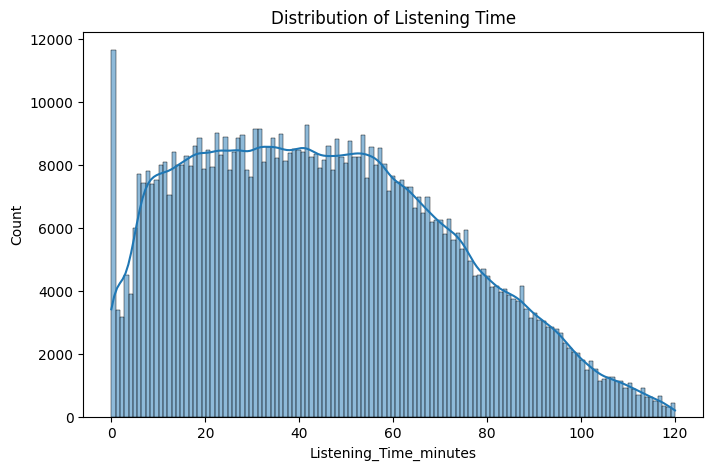

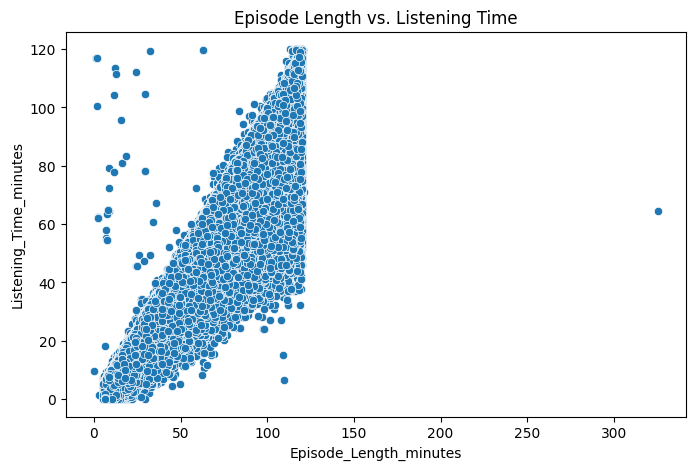

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable
plt.figure(figsize=(8,5))
sns.histplot(train[target_col], kde=True)
plt.title("Distribution of Listening Time")
plt.show()

# Relationship between a numeric feature and the target
plt.figure(figsize=(8,5))
sns.scatterplot(x=train['Episode_Length_minutes'], y=train[target_col])
plt.title("Episode Length vs. Listening Time")
plt.show()

In [ ]:
# Separate features (X) and target (y) for training data.
X = train[categorical_features + numeric_features]
y = train[target_col]

# Split the training data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create pipelines for numeric and categorical features.
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # Impute missing numeric values.
    ('scaler', StandardScaler())                       # Standardize numeric features.
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing categorical values.
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))    # One-hot encode categorical features.
])

In [ ]:
"""""# model 1 random forest
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# 2) Build your Pipeline, using the correct class name
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor',    RandomForestRegressor(random_state=42))
])""""

SyntaxError: unterminated string literal (detected at line 13) (<ipython-input-13-f9cc3acd3ae1>, line 13)

In [ ]:
"""""model_pipeline.fit(X_train, y_train)
y_val_pred = model_pipeline.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Validation Root Mean Squared Error with Random Forest:", rmse)""""

In [ ]:
""""# model 2 xgb
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(
        max_iter=200,
        learning_rate=0.1,
        max_depth=10,
        random_state=42
    ))
])""""

In [ ]:
""""gb_pipeline.fit(X_train, y_train)

y_val_pred = gb_pipeline.predict(X_val)

mse  = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)

print("GBDT validation RMSE:", rmse)"""""

In [ ]:
"""""preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
], sparse_threshold=0)

# 3) Build your RandomForest pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',    RandomForestRegressor(
                        n_estimators=125,
                        max_features='sqrt',
                        max_depth=25,
                        n_jobs=-1,
                        random_state=42
                    ))
])

# 4) Define hyperparameter search space
param_distributions = {
    'regressor__n_estimators':      [50, 100, 125,],
    'regressor__max_depth':         [None, 10, 20],
    'regressor__max_features':      ['sqrt', 'log2', 0.2],
    'regressor__min_samples_split': [2, 3, 5],
    'regressor__min_samples_leaf':  [1, 2, 4],
    'regressor__bootstrap':         [True, False]
}

# 5) Set up and run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator        = model_pipeline,
    param_distributions = param_distributions,
    n_iter           = 10,
    scoring          = 'neg_mean_squared_error',
    cv               = 5,
    verbose          = 1,
    random_state     = 42,
    n_jobs           = -1
) """"

In [ ]:
"""""random_search.fit(X_train, y_train)

# 6) Report best results
best_rmse = np.sqrt(-random_search.best_score_)
print("Best CV RMSE:", best_rmse)
print("Best params:", random_search.best_params_)

# Grab the tuned pipeline
best_model = random_search.best_estimator_ """"

In [ ]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# 2) Pipeline with a placeholder regressor
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42))
])

"""" old lgbm
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# build the pipeline with the new LGBM settings
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=1_000,    # high ceiling
        learning_rate=0.05,    # smaller learning rate
        max_depth=10,
        random_state=42
    ))
]) """

'" old lgbm \npreprocessor = ColumnTransformer([\n    (\'num\', numeric_pipeline, numeric_features),\n    (\'cat\', categorical_pipeline, categorical_features)\n])\n\n# build the pipeline with the new LGBM settings\nlgbm_pipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'regressor\', LGBMRegressor(\n        n_estimators=1_000,    # high ceiling\n        learning_rate=0.05,    # smaller learning rate\n        max_depth=10,\n        random_state=42\n    ))\n]) '

In [ ]:
param_dist = {
    'regressor__num_leaves':        randint(31, 300),
    'regressor__min_child_samples': randint(5, 200),
    'regressor__subsample':         uniform(0.7, 0.3),
    'regressor__colsample_bytree':  uniform(0.5, 0.4),
    'regressor__reg_alpha':         uniform(0.0, 0.7),
    'regressor__reg_lambda':        uniform(0.0, 0.7),
    'regressor__learning_rate': uniform(0.01, 0.03),
    'regressor__n_estimators': randint(1000, 3000)
}

search = RandomizedSearchCV(
    lgbm_pipeline,                         # your pipeline
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=4,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

# ---- 3. Optionally set up early stopping (requires validation set) ----
fit_params = {
    "regressor__early_stopping_rounds": 50,
    "regressor__eval_metric": "rmse",
    "regressor__eval_set": [(X_val, y_val)],   # must define X_val and y_val ahead
    "regressor__verbose": False
}

In [ ]:
# ---- 4. Run the search ----
search.fit(X_train, y_train)

# ---- 5. Output results ----
print("Best Parameters:", search.best_params_)
print("CV RMSE (Cross-Validated):", -search.best_score_)

# ---- 6. Evaluate best model on hold-out validation set ----
best_model = search.best_estimator_
y_val_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation RMSE (Hold-out):", rmse)

# ---- 7. Save the best model ----
joblib.dump(best_model, "best_lgbm_model.pkl")

Fitting 4 folds for each of 30 candidates, totalling 120 fits


In [ ]:
"""" old lgbm
preprocessor.fit(X_train)

# 2) Manually transform VAL
X_val_proc = preprocessor.transform(X_val)

# 3) Now train the pipeline with a processed eval_set
lgbm_pipeline.fit(
    X_train, y_train,
    regressor__eval_set=[(X_val_proc, y_val)],
    regressor__eval_metric='rmse',
    regressor__feature_name='auto'
)

# 4) And compute RMSE in the usual way
y_val_pred = lgbm_pipeline.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("RMSE:", rmse)

In [ ]:
test_preds = best_model.predict(test)

test_preds_df = pd.DataFrame({'Listening_Time_minutes': test_preds}, index=test.index)
test_preds_df.to_csv("submission.csv", index_label="id")

print("Submission file created successfully!")